<img src="https://pmarote.net/tcc/icmc_logo.png"  width="192px" align="right">
<p style="text-align: center; font-size: 200%; font-weight: bold; margin-top: 10px;"><b>UNIVERSIDADE DE SÃO PAULO</b></a></p>
<p style="text-align: center; font-size: 150%; font-weight: bold; margin-top: 10px;">Instituto de Ciências Matemáticas e de Computação</a></p><br>

---
### <div style="text-align: center"><font color="navy">Uso de técnicas de processamento de linguagem natural:<br><br>Aplicação em Decisões do Contencioso Administrativo Fiscal na Secretaria da Fazenda do Estado de São Paulo.</font></div>
### <div style="text-align: left"><font color= #333>Paulo Ricardo dos Santos Olim Marote<br><br>Trabalho de Conclusão de Curso - MBA em Ciência de Dados (CEMEAI)</font></div>
- **Parte I - Concepção, implantação, <i>web scraping</i>, estruturação, modelagem e tratamento de dados**
<p style="text-align: right; font-size: 100%; opacity: 0.8; margin-top: 0px;">USP - São Carlos - 2023</p>

## 🚴 Carregamento de Bibliotecas Auxiliares e AIIMs já baixados anteriormente
- Antes de iniciar, é necessário baixar as bibliotecas necessárias, desenvolvidas para este TCC e gravar em /content/core
- Esta biblioteca encontra-se no github do autor, na pasta /core, no link https://github.com/pmarote/tcc
- Adicionalmente, para fins de celeridade, é carregado em /content/var/www/ milhares de AIIMs já anteriormente baixados, tendo em vista que o processo de <i>web scraping</i> é, por sua natureza, um pouco lento

In [ ]:
import os

if not os.path.exists("/content/src/"):
    print('- Carregando o código fonte disponível no github para /content/src/')
    !mkdir -p /content/src/
    !git clone -q https://github.com/pmarote/tcc.git /content/src/tcc
else:
    print('- Código fonte de github já se encontra carregada em /content/src/')

if not os.path.exists("/content/core/"):
    print('- Criando pasta /content/core/')
    !mkdir -p /content/core/
    print('- Copiando pasta /content/src/tcc/core/ para /content/core/')
    !cp -r /content/src/tcc/core/ /content/
else:
    print('- Pasta /content/core/ já se encontra carregada')

if not os.path.exists("/content/var/"):
    print('\n- Criando a pasta /content/var/ para armazenar todos os dados')
    !mkdir -p /content/var/
else:
    print('- Pasta /content/var/ já se encontra criada')

if not os.path.exists("/content/var/www/"):
    #01/2024 - Google Drive da Usp começou a dar erro ao efetuar download direto, do tipo "the file have had many accesses"
    #print('- Carregando os dados de AIIMs já lidos anteriormente, em /content/var/www/, de link público do google drive do autor')
    #!gdown 1ZT8spKS0gRJ6UMCy7jf61Lx9_Fw_HWHj
    print('\n- Carregando os dados de AIIMs já lidos anteriormente, em /content/var/www/, de link público de reposítório do autor')
    #01/2024 - Houve a necessidade de separação em dois arquivos .zip, em razão do limite de 2Gb do tamanho de arquivo do reposítório
    !wget --no-check-certificate 'https://www.pmarote.net/tcc/var_www_4117000_4124999.zip' -O var_www_4117000_4124999.zip
    !wget --no-check-certificate 'https://www.pmarote.net/tcc/var_www_4125000_4129999.zip' -O var_www_4125000_4129999.zip
    print("- Arquivos de dados 'var_www.zip' baixado com sucesso a partir de link público do google drive")
    print("- Descompactando o conteúdo para a pasta /content/var/www/ . Aguarde a execução completa.")
    !unzip -q /content/var_www_4117000_4124999.zip -d /content/var/
    !unzip -q /content/var_www_4125000_4129999.zip -d /content/var/
    #01/2024 - os 4 comandos abaixo porque os zips estão com diretórios de forma diferente
    !mv /content/var/var_www_4117000_4124999/www /content/var/www
    !mv /content/var/var_www_4125000_4129999/www/* /content/var/www
    !rmdir /content/var/var_www_4117000_4124999
    !rmdir /content/var/var_www_4125000_4129999/www
    !rmdir /content/var/var_www_4125000_4129999
    !rm /content/var_www_4117000_4124999.zip
    !rm /content/var_www_4125000_4129999.zip
    print('- Finalizado!')
else:
    print('- A pasta /content/var/www/ com os dados de AIIMs anteriores já se encontra criada e carregada')

- Carregando o código fonte disponível no github para /content/src/
- Criando pasta /content/core/
- Copiando pasta /content/src/tcc/core/ para /content/core/

- Criando a pasta /content/var/ para armazenar todos os dados

- Carregando os dados de AIIMs já lidos anteriormente, em /content/var/www/, de link público de reposítório do autor
--2024-01-15 12:45:24--  https://www.pmarote.net/tcc/var_www_4117000_4124999.zip
Resolving www.pmarote.net (www.pmarote.net)... 64.90.53.133
Connecting to www.pmarote.net (www.pmarote.net)|64.90.53.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1748032982 (1.6G) [application/zip]
Saving to: ‘var_www_4117000_4124999.zip’

var_www_4117000_412 100%[===================>]   1.63G  20.8MB/s    in 82s     

2024-01-15 12:46:47 (20.3 MB/s) - ‘var_www_4117000_4124999.zip’ saved [1748032982/1748032982]

--2024-01-15 12:46:47--  https://www.pmarote.net/tcc/var_www_4125000_4129999.zip
Resolving www.pmarote.net (www.pmarote.net)... 64

In [ ]:
!rmdir /content/var/var_www_4117000_4124999
!rmdir /content/var/var_www_4125000_4129999

## 🔛 Importações e Inicialização
  - Código inicial, importando as bibliotecas necessárias
  - Aqui também são definidas algumas funções 'helpers' para utilização nos códigos, como de formatação de números para português-Brasil

In [ ]:
import os
import ipywidgets as widgets
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output

import core  # apenas insere o diretório ./core em sys.path
from Config import Config
from WebScraper import WebScraper
from Db import Db
config = Config.getConfigs()
webscraper = WebScraper(config['CWEB_DIR'])
db = Db(config['VAR_DIR'])
print("config = ", config)

# duas funções para dar uma melhor formatação em português
def int_f(val):
    return "{:,}".format(val).replace(',','.')
def two_dec_f(val):
    return "{:,.2f}".format(val).replace(',','#').replace('.',',').replace('#','.')
# styler em português para pandas
def df_style(styler):
    styler.format(lambda v: f'{v:,.2f}'.replace(".", "#").
              replace(",", ".").replace("#", ",") if isinstance(v, float) else v)
    styler.applymap(lambda v: 'color:red;' if not isinstance(v, str) and v < 0 else None)
    styler.applymap(lambda v: 'opacity: 80%;'
                    if not isinstance(v, str) and abs(v) < 10000 else None)
    return styler


Banco de dados /content/var/tcc.db inexistente... Criando...
config =  {'SRC_DIR': '/content', 'VAR_DIR': '/content/var', 'CWEB_DIR': '/content/var/www'}


## 🏁 <i>Web Scraper</i>
  - Execute para habilitar os widgets
  - Automaticamente, o campo AIIM Inicial será preenchido com o próximo a ser baixado, ou seja, o número do último já carregado, adicionado de 1
  - O AIIM final é o AIIM Inicial mais 100, mas pode ser alterado a vontade
  - Clique no botão 'Baixa AIIMs" para iniciar o <i>Web Scraper</i>
  - Mas, como no início já foi carregado em em /content/var/www/ milhares de AIIMs anteriormente baixados, não há necessidade de baixar AIIMs adicionais. Assim, neste momento, este trecho é utilizado apenas para teste e verificação do funcionamento do Web Scraper

In [ ]:
# Criando os widgets
aiim_ini = widgets.Text(value=str(webscraper.get_next_aiim_nr()), description='AIIM Inicial:')
aiim_fin = widgets.Text(value=str(webscraper.get_next_aiim_nr() + 100), description='AIIM Final:')
baixa_button = widgets.Button(description='Baixa AIIMs')

# Definindo as ações dos botões
def on_baixa_button_clicked(b):
    i_aiim_ini = int(aiim_ini.value)
    i_aiim_fin = int(aiim_fin.value)
    while(i_aiim_ini <= i_aiim_fin):
        res2 = webscraper.baixa_aiim(str(i_aiim_ini))
        if (res2 is not None):
            i_aiim_ini += 1
        else:
            break

baixa_button.on_click(on_baixa_button_clicked)
display(aiim_ini, aiim_fin, baixa_button)

Text(value='4130000', description='AIIM Inicial:')

Text(value='4130100', description='AIIM Final:')

Button(description='Baixa AIIMs', style=ButtonStyle())

## 👀 Visualização analitica de AIIMs, por número
  - Execute para habilitar os widgets
  - Automaticamente, o campo AIIM será preenchido com o valor do primeiro baixado
  - Clique no botão para gerar o link de visualização
  - Os dados da tela de visualização são os mesmos utilizados pelo Web Scraper


In [ ]:
# Criando os widgets
aiim_view = widgets.Text(value=str(webscraper.get_first_aiim_nr()), description='Nro AIIM:')
link_button = widgets.Button(description='Gera link')

def view_display(nro_aiim: str):
    display(aiim_view, link_button)
    display(HTML(f'<a href="https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim={nro_aiim}" target="_blank">Visualizar AIIM {nro_aiim}</a>'))

def on_link_button_clicked(b):
    clear_output()
    view_display(aiim_view.value)

link_button.on_click(on_link_button_clicked)
view_display(aiim_view.value)

Text(value='4117000', description='Nro AIIM:')

Button(description='Gera link', style=ButtonStyle())

## ♻️ Conversão dos dados obtidos da internet para banco de dados SQL
  - Basicamente, reinicializa o banco de dados SQLite em /content/var/tcc.db e insere com os dados dos AIIMs obtidos da internet (<i>web scraper</i>) e já baixados, que estão em /content/var/www, utilizando a biblioteca Beautiful Soup
  - Esta célula deve sempre ser executada, embora demore um pouco


In [ ]:
def preenche_tcc_db():
    db.exec("DELETE FROM aiim;")
    db.exec("DELETE FROM aiim_mov;")
    db.exec("DELETE FROM aiim_decis;")
    print('Carregando os AIIMs e mostrando os números de 500 em 500, ',
          'para acompanhar o andamento')
    for i in range(webscraper.get_first_aiim_nr(), webscraper.get_next_aiim_nr()):
        html_file = os.path.join(config['CWEB_DIR'], f'{i}.html')
        db.html_to_db(html_file)
        print('.', end='') if i % 500 != 0 else print('\n', i, end='')
    db.conn.commit()
    print(f"\nFinalizado!")

preenche_tcc_db()


Carregando os AIIMs e mostrando os números de 500 em 500,  para acompanhar o andamento

 4117000...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 4117500............................................................................................................................................................................................................................................................................................................................................................................................................

## 🔍 Reindexação, carregamento em dataframes e visualização das tabelas de tcc.db
  - Ao utilizar <i>dataframes</i> em <i>Pandas</i>, é importante definir uma coluna como índice, o que é equivalente à definição de uma chave primária em termos de banco de dados relacionais. Definir uma coluna como índice também é importante para fins de melhora de performance, bem como para realizar operações combinando diferentes DataFrames
  - Conforme definição dos SQLs (abaixo), é de se observar que em todas as tabelas o campo numero (Número do AIIM) é inteiro e também faz parte da chave primária
  - Assim, após a criação de cada Dataframe, efetua-se a definição do número do AIIM como índice, com inplace=True, para fins de modificação do DataFrame original
  - Por fim, são geradas visualizações SQL básicas da base de dados SQLite em /content/var/tcc.db

In [ ]:
display(HTML('<h3>Lista de Tabelas:</h3>'))
sql = """
SELECT * FROM sqlite_master WHERE type = 'table'
"""
df_tabelas = pd.read_sql_query(sql, db.conn)
display(df_tabelas.head().style.pipe(df_style))

qtd_aiims = db.sql_to_list('SELECT count(*) FROM aiim')[0][0]
nro_ini = str(db.sql_to_list('SELECT min(numero) FROM aiim')[0][0])
nro_fin = str(db.sql_to_list('SELECT max(numero) FROM aiim')[0][0])
display(HTML('<h3>Dataframe <i>df_aiim</i> - '
             + f' Total de AIIMs: {int_f(qtd_aiims)}'
             + f' ( de {int_f(int(nro_ini))} a {int_f(int(nro_fin))} )'
             + '</h3>'))
sql = """
SELECT * FROM aiim
"""
df_aiim = pd.read_sql_query(sql, db.conn)
df_aiim.set_index('numero', inplace=True)
display(df_aiim.head())
display(HTML('<h3>Dataframe <i>df_aiim_mov</i> - Itens de AIIMs já carregados: (amostra dos 5 primeiros)</h3>'))
sql = """
SELECT * FROM aiim_mov
"""
df_aiim_mov = pd.read_sql_query(sql, db.conn)
df_aiim_mov.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_mov['data'] = pd.to_datetime(df_aiim_mov['data'])
df_aiim_mov['data'] = df_aiim_mov['data'].dt.date
display(df_aiim_mov.head())

display(HTML('<h3>Dataframe <i>df_aiim_decis</i> - Decisões de AIIMs já carregados: (amostra dos 5 primeiros)</h3>'))
sql = """
SELECT * FROM aiim_decis
"""
df_aiim_decis = pd.read_sql_query(sql, db.conn)
df_aiim_decis.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_decis['data'] = pd.to_datetime(df_aiim_decis['data'])
df_aiim_decis['data'] = df_aiim_decis['data'].dt.date
display(df_aiim_decis.head())


,type,name,tbl_name,rootpage,sql
0,table,aiim,aiim,2,"CREATE TABLE aiim (numero INT PRIMARY KEY, nro_comp TEXT, drt TEXT, autuado TEXT, advogado TEXT, assunto TEXT, fase_proc TEXT)"
1,table,aiim_mov,aiim_mov,4,"CREATE TABLE aiim_mov (numero INT, item INT, data TEXT, descri TEXT, PRIMARY KEY (numero, item))"
2,table,aiim_decis,aiim_decis,6,"CREATE TABLE aiim_decis (numero INT, item INT, data TEXT, recurso TEXT, pdf_link TEXT, PRIMARY KEY (numero, item))"


,nro_comp,drt,autuado,advogado,assunto,fase_proc
numero,,,,,,
4117000,4.117.000-3,CAMPINAS,STARHOUSE INFORMATICA EIRELI - EPP,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4117001,4.117.001-5,CAPITAL III,GALERIA DE ARTE RAQUEL ARNAUD LTDA,CARLOS APARECIDO BONI,,DEFESA
4117002,4.117.002-7,OSASCO,BRASLOG LOGÍSTICA LTDA.,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4117004,4.117.004-0,CAMPINAS,BENTLY DO BRASIL LTDA,NENHUM ADVOGADO/PROCURADOR CADASTRADO,ICMS - FALTA DE PAGAMENTO DE IMPOSTO<br>Falta/...,DEFESA
4117005,4.117.005-2,CAPITAL I,J M MEAT COMÉRCIO DE CARNES - EIRELI - EPP,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA


,item,data,descri
numero,,,
4117000,0,2018-10-25,Notificação do AIIM
4117000,1,2018-11-27,Decurso de Prazo (STARHOUSE INFORMATICA EIRELI...
4117000,2,2019-01-09,AIIM liquidado
4117001,0,2018-11-14,Notificação do AIIM
4117001,1,2018-12-21,Decurso de Prazo (GALERIA DE ARTE RAQUEL ARNAU...


,item,data,recurso,pdf_link
numero,,,,
4117008,0,2019-01-28,DEFESA,4117008voto4797078.pdf
4117008,1,2019-11-12,DEFESA,4117008voto4823670.pdf
4117008,2,2020-03-13,RECURSO DE OFICIO,4117008voto4826956.pdf
4117010,0,2019-02-12,DEFESA,4117010voto4810391.pdf
4117014,0,2019-02-01,DEFESA,4117014voto4808460.pdf


## 🔍 Pré-análise dos dados
  - Distribuição das Decisões dos AIIMs:

In [ ]:
sql = """
SELECT recurso, count(recurso) AS qtd FROM
(SELECT *
FROM aiim_mov AS A
LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
WHERE A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')
GROUP BY recurso
HAVING qtd > 0
"""
df_dec = pd.read_sql_query(sql, db.conn)
df_dec['%tot_aiims'] = (df_dec['qtd'] / int(qtd_aiims)) * 100
total_qtd = df_dec['qtd'].sum()
df_dec['%decis_c_def'] = (df_dec['qtd'] / int(total_qtd)) * 100
msg = f'De {int_f(qtd_aiims)} carregados, há {int_f(total_qtd)}'
msg += f' AIIMs (' + two_dec_f(total_qtd / qtd_aiims * 100)
msg += f'%) com decisões, assim distribuídos:<br>(Tipos Diferentes: {df_dec.shape[0]})'
display(HTML(f'<h3>{msg}</h3>'))
display(df_dec.style.pipe(df_style))

,recurso,qtd,%tot_aiims,%decis_c_def
0,DEFESA,2975,"26,01","83,71"
1,RECURSO DE OFICIO,69,"0,60","1,94"
2,RECURSO VOLUNTARIO,462,"4,04","13,00"
3,RECURSO VOLUNTARIO / OFICIO,14,"0,12","0,39"
4,RETIFICAÇÃO,34,"0,30","0,96"


## 🧹 Seleção e Limpeza dos Dados (1)

Conforme se verifica da primeira análise, acima:
  - Dos AIIMs carregados, cerca de 31% dos mesmos possuem decisões
  - Dos que possuem decisões, estas majoritariamente são do tipo "DEFESA", ou seja, as decisões de primeira instância administrativa
  - Assim, para maior padronização, considerando a classe majoritária "DEFESA", selecionaremos apenas este tipo de decisão para estudo neste TCC
  - Conforme SQL abaixo, para seleção dos dados, é feita uma ligação de cada movimento de AIIM (A) com o imediatamente posterior (B), porque o <i>link</i> do arquivo .pdf e tipo de decisão encontra-se nesse movimento seguinte
  - Ainda conforme SQL abaixo, há um "subquery agrupando por número de AIIM". Nesse sentido, caso haja duas ou mais decisões de primeiro grau para o mesmo AIIM, somente a última deve ser utilizada. Essa hipótese de duas decisões pode ocorrer quando, em segunda instância, o primeiro julgamento é anulado para proferir nova decisão. Ou, em outras palavras, para esse <i>dataframe</i> o campo número passa a ter valores únicos, não há valores duplicados. Por isso uma pequena diminuição na quantidade total, em comparação a primeira análise, acima

In [ ]:
sql = """
SELECT numero, item, max(data) AS data, julgado, it_posterior, public, recurso, pdf_link
FROM
  (SELECT A.numero, A.item, A.data, A.descri AS julgado, B.item AS it_posterior, B.descri AS public, C.recurso, C.pdf_link
  FROM aiim_mov AS A
  LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
  LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
  WHERE C.recurso = 'DEFESA'
    AND (A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')) AS sbq1
GROUP BY numero
"""
df_dpi = pd.read_sql_query(sql, db.conn)
df_dpi.set_index('numero', inplace=True)
display(HTML(f'<h3>Busca de Decisões de Primeira Instância (head): (Qtd Total: {int_f(df_dpi.shape[0])})</h3>'))
display(df_dpi.head())

df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(df_distr_julg.style.pipe(df_style))


,item,data,julgado,it_posterior,public,recurso,pdf_link
numero,,,,,,,
4117008,12,2019-11-08,Julgamento: REDUZIDO o Auto de Infração e Impo...,13,Publicação no Diário Eletrônico - Edição no. 2...,DEFESA,4117008voto4823670.pdf
4117010,6,2019-02-11,Julgamento: MANTIDO o Auto de Infração e Impos...,7,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4117010voto4810391.pdf
4117014,4,2019-01-31,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4117014voto4808460.pdf
4117017,4,2019-06-07,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4117017voto4818989.pdf
4117018,5,2021-03-10,Julgamento: MANTIDO o Auto de Infração e Impos...,6,Publicação no Diário Eletrônico - Edição no. 2...,DEFESA,4117018voto4846151.pdf


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,219,"7,60"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,2319,"80,52"
2,Julgamento: REDUZIDO o Auto de Infração e Imposição de Multa,342,"11,88"


##🧹 Seleção e Limpeza dos Dados (2)

Em continuação à pré-analise dos dados, verifica-se acima o seguinte:
  - Dos AIIMs com decisões de primeira instância administrativa, ou seja, aqueles que são julgados por Delegacias Tributárias de Julgamento (DTJs), cerca de 7,6% foram cancelados, aproximadamente 80,5% mantidos e os demais tiveram seus valores reduzidos
  - Neste TCC temos como objetivo a análise de padrões dos dados das decisões proferidas. Nesse sentido, tomamos a decisão de retirar do objeto de análise as decisões do tipo "REDUZIDO o AIIM", porque estes tipos de decisões possuem alto grau de variação - podem ser cancelamento de alguns itens e manutenção de outros ou podem ser ainda reducão específica de alguns itens
  - Por isso, para maior padronização, neste TCC, a partir de agora o <i>dataframe</i> 'df_dpi' será reconfigurado para decisões apenas do tipo "MANTIDO" ou "CANCELADO", conforme a seguir:

In [ ]:
# Criar uma máscara booleana para as linhas onde 'julgado' contém 'REDUZIDO', removendo as linhas em seguida
mask = df_dpi['julgado'].str.contains('REDUZIDO')
df_dpi = df_dpi[~mask]
# refazendo o agrupamento
df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(HTML(f'<h3>(O dataframe df_dpi foi reconfigurado para ter conter agora apenas CANCELADOs e MANTIDOs)</h3>'))
display(df_distr_julg.style.pipe(df_style))


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,219,"8,63"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,2319,"91,37"


## 🔁 Conversão de formatos: arquivos .pdf para .txt
  - Para possilitar a análise dos dados, é necessária a conversão das decisões contidas nos arquivos .pdf para o formato .txt. Neste trabalho, está sendo utilizada a biblioteca 'pdftotext'
  - Conforme acima explicado, esta conversão é apenas para decisões do tipo "MANTIDO" ou "CANCELADO", selecionados com base nas linhas do </i>dataframe</i> 'df_dpi'
  - Os arquivos no formato .txt são salvos em /content/var/txt

In [ ]:
%%capture
# pdftotext não está disponível nativamente no GoogleColab
# assim, na primeira utilização, necessário executar este código
!sudo apt-get update
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext


In [ ]:
import pdftotext
import shutil
import os

display(HTML(f'<h3>Convertendo cada decisão da seleção anterior' +
             f' (dataframe df_dpi - Sentenças de Primeiro Grau)' +
             f' para arquivo .txt na pasta /var/txt</h3>'))

txt_dir = os.path.join(config['VAR_DIR'], 'txt')
if os.path.exists(txt_dir):
    # se existir /var/txt, esvazia antes de criar novamente
    shutil.rmtree(txt_dir)
os.makedirs(txt_dir)
for index, row in df_dpi.iterrows():
    print(row['pdf_link'], end=' ') if index % 100 != 0 else print(row['pdf_link'])
    # Abre o arquivo PDF e converte para texto
    pdf_file = os.path.join(config['CWEB_DIR'], row['pdf_link'])
    txt_file = os.path.join(txt_dir, row['pdf_link'][:-4] + '.txt')
    with open(pdf_file, "rb") as f:
        pdf = pdftotext.PDF(f)
    with open(txt_file, "w") as f:
        for page in pdf:
            f.write(page)
    # ao encerrar o with, automaticamete é fechada a gravação
    if not os.path.exists(txt_file):
        print(f"Erro fatal... O arquivo {txt_file} não "
              + "foi gerado por pdftotext...")
        break
print("\nFinalizado!")

4117010voto4810391.pdf 4117014voto4808460.pdf 4117017voto4818989.pdf 4117018voto4846151.pdf 4117022voto4797272.pdf 4117025voto4812293.pdf 4117028voto4808099.pdf 4117033voto4814836.pdf 4117035voto4815992.pdf 4117055voto4827859.pdf 4117056voto4808767.pdf 4117062voto4812115.pdf 4117063voto4808513.pdf 4117078voto4813514.pdf 4117086voto4817289.pdf 4117093voto4812561.pdf 4117096voto4814719.pdf 4117097voto4815771.pdf 4117100voto4795178.pdf
4117102voto4795527.pdf 4117114voto4816116.pdf 4117124voto4811006.pdf 4117126voto4816509.pdf 4117127voto4818515.pdf 4117133voto4796462.pdf 4117139voto4795989.pdf 4117142voto4818473.pdf 4117143voto4794190.pdf 4117145voto4817491.pdf 4117152voto4813404.pdf 4117161voto4839826.pdf 4117163voto4819990.pdf 4117171voto4797045.pdf 4117172voto4816470.pdf 4117176voto4819518.pdf 4117177voto4819494.pdf 4117178voto4815949.pdf 4117183voto4818039.pdf 4117204voto4811220.pdf 4117205voto4820340.pdf 4117206voto4820339.pdf 4117207voto4821345.pdf 4117210voto4809542.pdf 4117218voto

##🧹 Seleção e Limpeza dos Dados (3)

- Das decisões que serão objeto de análise, temos agora também em formato .txt
- Neste trecho extrairemos as ementas das decisões, que serão objeto de análise de aprendizado de máquina no notebook 'tcc_am.ipynb'
  - Para a referida extração das ementas, foram verificados os padrões das decisões e desenvolvidos métodos específicos, conforme código abaixo
  - Necessário, também, neste ato, uma limpeza de caracteres que podem atrapalhar a análise, como remoção de códigos ASCII abaixo de 32, como nova linha (\n), retorno de carro (\r), nova página (\f), tabulação (\t)
  - As ementas são salvas em /content/var/ementas e também no <i>dataframe</i> 'df_detec_ementas'
  - Ao final, é gerado também /content/ementas_nd.zip dos arquivos das ementas não detectadas, para download, possibilitando reestudo e aperfeiçoamento do código de extração de ementas, dentro dos conceitos do modelo CRISP-DM, entendendo o problema, modelando e reavaliando
- Em outras palavras, o objetivo do <i>dataframe</i> 'df_detec_ementas' criado neste momento é guardar os dados de detecção e extração das ementas extraídas a partir das decisões, para criação posterior de outras outras colunas, com o objetivo de aprendizado de máquina, treinamento e teste



In [ ]:
%%capture
# unidecode é aqui usado basicamente para converter caracteres acentuados para não acentuados
# não está disponível nativamente no GoogleColab e, assim, na primeira utilização, necessário executar este código
!pip install unidecode

In [ ]:
import glob
import re
import zipfile
from unidecode import unidecode

# Inicializar a lista de dados para adicionar ao dataframe no final
dados = []
# Inicializar a pasta /content/var/ementas
ementas_dir = os.path.join(config['VAR_DIR'], 'ementas')
if os.path.exists(ementas_dir):
    shutil.rmtree(ementas_dir)
os.makedirs(ementas_dir)

txt_path = os.path.join(config['VAR_DIR'], 'txt', "*.txt")
# Listar todos os arquivos .txt
arquivos_txt = glob.glob(txt_path)

i = 0
for arquivo in arquivos_txt:
    with open(arquivo, 'r', encoding='utf-8') as f:
        conteudo = f.read()

    # Procurar o texto entre "EMENTA" e qualquer um destes fins
    # Removendo acentos e transformando para minúscula
    conteudo_busca = unidecode(conteudo).lower()
    # atenção, a busca é em minúscula e sem acento
    inicio = conteudo_busca.find("ementa")
    fim_ementa1 = conteudo_busca.find("pressupostos de conhecimento")
    fim_ementa2 = conteudo_busca.find("juizo de admissibilidade")
    fim_ementa3 = conteudo_busca.find("pressupostos de admissibilidade")
    fim_ementa4 = conteudo_busca.find("credito tributario mantido")
    fim_ementa5 = conteudo_busca.find("credito tributario cancelado")
    fim_ementa6 = conteudo_busca.find("nao conhecimento")
    fim_ementa7 = conteudo_busca.find("procedente")
    fim_ementa8 = conteudo_busca.find("intempestiv")
    fim = -1
    if fim_ementa1 > inicio:
        fim = fim_ementa1
    elif fim_ementa2 > inicio:
        fim = fim_ementa2
    elif fim_ementa3 > inicio:
        fim = fim_ementa3
    elif fim_ementa4 > inicio:
        fim = fim_ementa4 + 26
    elif fim_ementa5 > inicio:
        fim = fim_ementa5 + 28
    elif fim_ementa6 > inicio:
        fim = fim_ementa6 + 16
    elif fim_ementa7 > inicio:
        fim = fim_ementa7 + 10
    elif fim_ementa8 > inicio:
        fim = fim_ementa8 + 11

    txt_link = 'var/txt/' + os.path.basename(arquivo)
    ementa_link = 'var/ementas/' + os.path.basename(arquivo)
    pdf_link = 'var/www/' + os.path.basename(arquivo)[:-4] + ".pdf"
    if inicio != -1 and fim != -1:
        i += 1
        texto_desejado = conteudo[inicio:fim]
        # retirando mudança de linha
        texto_desejado = texto_desejado.replace('\n', ' ').replace('\r', ' ')
        # retirando mais que um espaço
        texto_desejado = re.sub(' +', ' ', texto_desejado)
        ementa = texto_desejado
    else:
        ementa = "Não consegui detectar a ementa!"
    # Substituir todos os caracteres de controle ASCII por uma string vazia
    ementa_limpa = re.sub('[\x00-\x1F]', ' ', ementa)
    with open(ementa_link, "w") as f:
        f.write(ementa_limpa)

    dados.append({'numero': int(os.path.basename(arquivo)[:7]),
                  'ementa': ementa_limpa.strip(),
                  'txt_link': txt_link, 'pdf_link': pdf_link,
                  'inicio': inicio, 'fim': fim})

df_detec_ementas = pd.DataFrame(dados)
df_detec_ementas.set_index('numero', inplace=True)
df_detec_ementas['nao_detec'] = df_detec_ementas['fim'].apply(lambda x: 'X' if x == -1 else '')
df_detec_ementas['icms'] = df_detec_ementas['ementa'].apply(lambda x: 'X' if 'icms' in str(x).lower() else '')
df_detec_ementas['itcmd'] = df_detec_ementas['ementa'].apply(lambda x: 'X' if 'itcmd' in str(x).lower() else '')
display(HTML(f'<h3>Dataframe df_detec_ementas - detecção e extração de ementa de cada decisão da pasta /var/txt'
             + f' . Qtd de linhas:{df_detec_ementas.shape[0]}</h3>'))
display(df_detec_ementas.head())

df_ementas_nd = df_detec_ementas[df_detec_ementas['nao_detec'] == 'X']
zip_file_path = os.path.join(config['SRC_DIR'], 'ementas_nd.zip')
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for index, row in df_ementas_nd.iterrows():
        pdf_file = os.path.join(config['SRC_DIR'], row['pdf_link'])
        zipf.write(pdf_file, arcname=row['pdf_link'])
        txt_file = os.path.join(config['SRC_DIR'], row['txt_link'])
        zipf.write(txt_file, arcname=row['txt_link'])
        ementa_link = os.path.join(config['VAR_DIR'], 'ementas',
                                   os.path.basename(row['txt_link']))
        ementa_arcname = os.path.join('var', 'ementas',
                                   os.path.basename(row['txt_link']))
        zipf.write(ementa_link, arcname=ementa_arcname)
del df_ementas_nd  # exclui porque é um dataframe temporário
display(HTML(f'<h3>Arquivo {zip_file_path} criado com sucesso a partir do dataframe df_ementas</h3>'))


,ementa,txt_link,pdf_link,inicio,fim,nao_detec,icms,itcmd
numero,,,,,,,,
4123071,"EMENTA ITCMD – Deixou de pagar o imposto, por ...",var/txt/4123071voto4821463.txt,var/www/4123071voto4821463.pdf,365,854,,,X
4119911,EMENTA ICMS: Falta de registro/escrituração de...,var/txt/4119911voto4818729.txt,var/www/4119911voto4818729.pdf,393,682,,X,
4125213,EMENTA ICMS – INFRAÇÕES RELATIVAS A SISTEMA EL...,var/txt/4125213voto4825459.txt,var/www/4125213voto4825459.pdf,365,970,,X,
4118801,EMENTA ITCMD – Falta de pagamento de ITCMD rel...,var/txt/4118801voto4816462.txt,var/www/4118801voto4816462.pdf,368,889,,,X
4121584,EMENTA ICMS. INFRAÇÃO I.1 – INFRAÇÃO DE CRÉDIT...,var/txt/4121584voto4819597.txt,var/www/4121584voto4819597.pdf,409,1687,,X,


##🧹 Seleção e Limpeza dos Dados (4)

  - Dentro do já explicado processo contínuo de melhoria, com analise dos resultados, o código vai sendo aperfeiçoado, buscando eficiência
  - A seguir, a análise e estudo dos primeiros padrões (no caso, 'icms' e 'itcmd')


In [ ]:
# Contar quantas vezes 'icms' aparece no campo 'ementa'
mask_icms = df_detec_ementas['ementa'].str.contains('icms', case=False, na=False)
qtd_icms = mask_icms.sum()
# Combinar as máscaras com o operador & (E lógico) e somar os True
mask_itcmd = df_detec_ementas['ementa'].str.contains('itcmd', case=False, na=False)
qtd_itcmd = mask_itcmd.sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms': {qtd_icms} ({two_dec_f(qtd_icms / df_detec_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões contendo 'itcmd': {qtd_itcmd} ({two_dec_f(qtd_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))

mask_nao_detec = df_detec_ementas['nao_detec'].eq('X')
qtd_nao_detec = mask_nao_detec.sum()
display(HTML(f"<h3>Quantidade de decisões com ementas não detectadas (erro): "
             + f"{qtd_nao_detec} ({two_dec_f(qtd_nao_detec / df_detec_ementas.shape[0] * 100)}%)</h3>"))
qtd_icms_itcmd = (mask_icms & mask_itcmd).sum()
qtd_not_icms_not_itcmd = (~mask_icms & ~mask_itcmd).sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms' E 'itcmd' (erro): {qtd_icms_itcmd} ({two_dec_f(qtd_icms_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões que não contém 'icms' nem contém 'itcmd' (multas, outras, etc - descartar): {qtd_not_icms_not_itcmd} ({two_dec_f(qtd_not_icms_not_itcmd / df_detec_ementas.shape[0] * 100)}%)</h3>"))
df_detec_ementas['eliminar'] = np.where(mask_nao_detec | (mask_icms & mask_itcmd) | (~mask_icms & ~mask_itcmd), 'X', '')

# Relacionando a coluna 'julgado' de df_dpi para df_ementas usando os índices como chave
df_detec_ementas['julgado'] = df_detec_ementas.index.map(df_dpi['julgado'])
# Retirar o início e fim, mantendo somente 'MANTIDO' ou 'CANCELADO'
df_detec_ementas['julgado'] = df_detec_ementas['julgado'].apply(lambda x: x[12:-40] if isinstance(x, str) else x)

# Criação da coluna 'imposto'
df_detec_ementas['imposto'] = np.where(df_detec_ementas['icms'] == 'X', 'ICMS',
                                 np.where(df_detec_ementas['itcmd'] == 'X', 'ITCMD', np.nan))
display(HTML(f"<h3>Dataframe df_detec_ementas com a coluna 'eliminar', 'julgado' e 'imposto' preenchida . Qtd de linhas:{df_detec_ementas.shape[0]}</h3>"))
display(df_detec_ementas.head())


,ementa,txt_link,pdf_link,inicio,fim,nao_detec,icms,itcmd,eliminar,julgado,imposto
numero,,,,,,,,,,,
4123071,"EMENTA ITCMD – Deixou de pagar o imposto, por ...",var/txt/4123071voto4821463.txt,var/www/4123071voto4821463.pdf,365,854,,,X,,MANTIDO,ITCMD
4119911,EMENTA ICMS: Falta de registro/escrituração de...,var/txt/4119911voto4818729.txt,var/www/4119911voto4818729.pdf,393,682,,X,,,MANTIDO,ICMS
4125213,EMENTA ICMS – INFRAÇÕES RELATIVAS A SISTEMA EL...,var/txt/4125213voto4825459.txt,var/www/4125213voto4825459.pdf,365,970,,X,,,MANTIDO,ICMS
4118801,EMENTA ITCMD – Falta de pagamento de ITCMD rel...,var/txt/4118801voto4816462.txt,var/www/4118801voto4816462.pdf,368,889,,,X,,CANCELADO,ITCMD
4121584,EMENTA ICMS. INFRAÇÃO I.1 – INFRAÇÃO DE CRÉDIT...,var/txt/4121584voto4819597.txt,var/www/4121584voto4819597.pdf,409,1687,,X,,,MANTIDO,ICMS


##🎯 Variáveis preditoras (<i>features</i>) e variáveis resposta (<i>targets</i>)
- Prosseguindo o estudo e análise dos dados, a seguir é criado o <i>dataframe</i> 'df_ementas', incluindo as definições necessárias para fins de aprendizado de máquina
  - Define-se neste momento os dois campos contendo as variáveis resposta (targets), que são as que vamos prever ou inferir a partir das variáveis preditoras. Também chamadas de variáveis de saída, bem como 'array alvo' (<i>Target array</i>), a variável resposta é geralmente unidimensional e, por convenção, é frequentemente armazenada em uma variável chamada de y, normalmente contido em um array <i>NumPy</i> ou em uma série <i>Pandas</i>.  Estas suas variáveis <i>target</i> são:
    - 'julgado': MANTIDO ou CANCELADO
    - 'imposto': ICMS ou ITCMD
  - É de se observar, assim, que o escopo deste trabalho é o chamado "problema de classificação", onde as variáveis <i>target</i> são classes/etiquetas de categoria, do tipo 'A' ou 'B', não se tratando assim de "problema de regressão", onde a variável <i>target</i> seria contínua, como, por exemplo, o preço de um imóvel
  - Em seguida, foi copiado o conteúdo de cada ementa e posteriormento a definição de num_palavras e num_caracteres, que são duas das primeiras variáveis preditoras (<i>features</i>), para fins de aprendizado de máquina. Também chamada de matriz de características (<i>Feature matrix</i>), por convenção, esta matriz de características é frequentemente armazenada em uma variável chamada X e está mais frequentemente contida em um array <i>NumPy</i> ou em um <i>DataFrame Pandas</i>


In [ ]:
# o comando abaixo cria df_ementas partir das linhas de df_detec_ementas, onde eliminar não é igual a 'X'
# A função reset_index() é usada para trazer o 'numero' (que estava como índice no df_detec_ementas)
#     de volta como uma coluna no df_ementas.
df_ementas = df_detec_ementas[df_detec_ementas['eliminar'] != 'X'][['julgado', 'imposto', 'ementa']].reset_index()
# por fim, o campo 'numero' volta a ser um índice
df_ementas.set_index('numero', inplace=True)

# criação das primeiras variáveis preditoras
df_ementas['num_palavras'] = df_ementas['ementa'].apply(lambda x: len(str(x).split(" ")))
df_ementas['num_caracteres'] = df_ementas['ementa'].str.len()  # inclusive espaços

display(HTML(f'<h3>Dataframe df_ementas - definição final, com targets. Qtd de linhas:{df_ementas.shape[0]}</h3>'))
display(df_ementas.head())


,julgado,imposto,ementa,num_palavras,num_caracteres
numero,,,,,
4123071,MANTIDO,ITCMD,"EMENTA ITCMD – Deixou de pagar o imposto, por ...",79,486
4119911,MANTIDO,ICMS,EMENTA ICMS: Falta de registro/escrituração de...,44,287
4125213,MANTIDO,ICMS,EMENTA ICMS – INFRAÇÕES RELATIVAS A SISTEMA EL...,94,602
4118801,CANCELADO,ITCMD,EMENTA ITCMD – Falta de pagamento de ITCMD rel...,75,519
4121584,MANTIDO,ICMS,EMENTA ICMS. INFRAÇÃO I.1 – INFRAÇÃO DE CRÉDIT...,185,1277


## 📉 Remoção de Outliers

- Outliers são valores que se desviam significativamente dos outros valores em um conjunto de dados. Eles podem surgir devido a variações na medição, ou por erros. Em muitos casos, é benéfico identificar e remover os outliers porque a presença dos mesmos pode distorcer significativamente os resultados e conclusões
- Conforme quadro abaixo, há ementas com número de palavras muito superior à média. É de se notar que, inicialmente, nem é possível a visualização do boxplot
- Verificado, trata-se na verdade de erros na extração das ementas, onde na verdade, nos casos muito acima da média, houve o retorno de praticamente a sentença completa e nos casos muito abaixo, algumas palavras como procedente ou improcedente vieram muito no início, antes do final da ementa, causando erro na extração da mesma
- Assim, utilizou-se o seguinte critério:
  - Há aproximadamente 2500 ementas, sendo que cerca de 20 com mais de 2000 caracteres foram eliminadas; no outro extremo, há também cerca de 20 com menos de 50 caracteres, que também foram eliminadas
- No quadro abaixo, os boxplots antes e depois da remoção de outliers

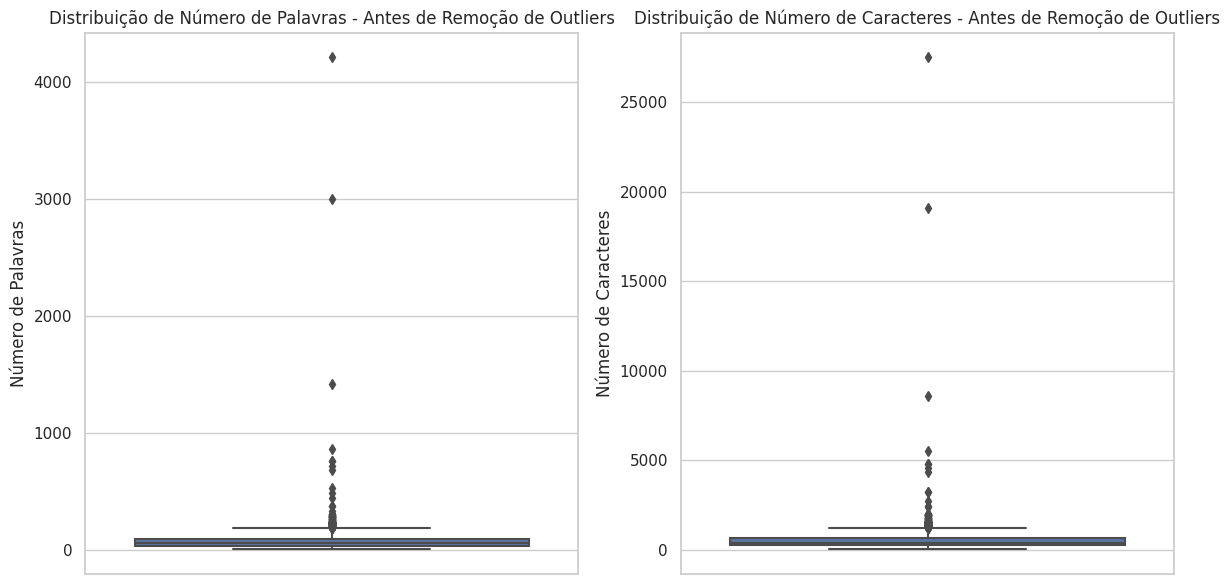

None

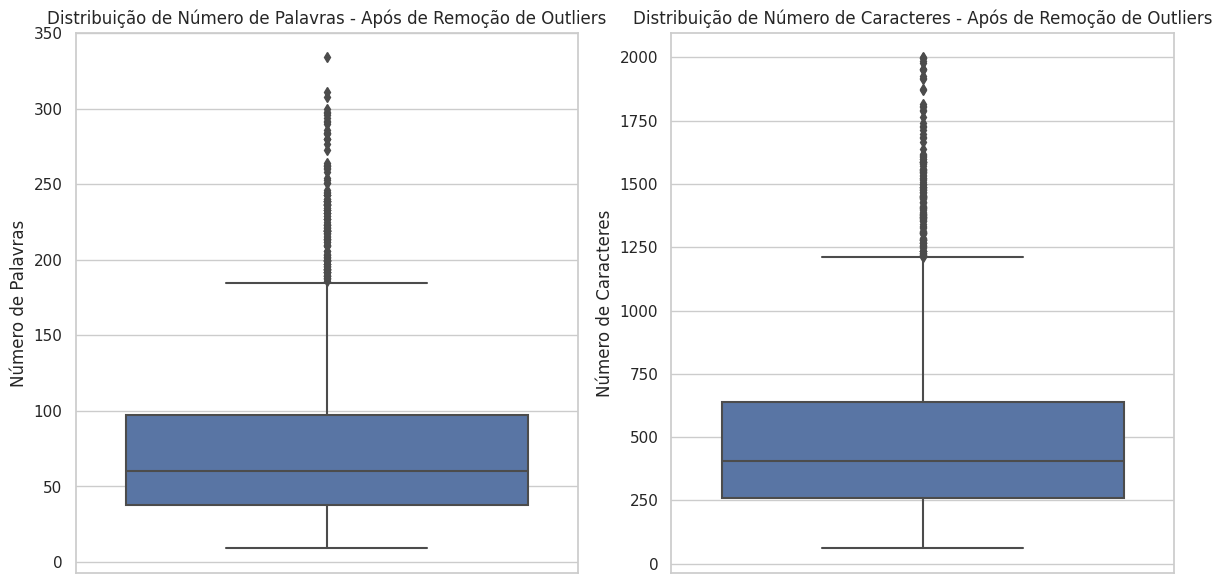

None

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=df_ementas["num_palavras"], ax=ax[0])
ax[0].set_title("Distribuição de Número de Palavras - Antes de Remoção de Outliers")
ax[0].set_ylabel("Número de Palavras")
sns.boxplot(y=df_ementas["num_caracteres"], ax=ax[1])
ax[1].set_title("Distribuição de Número de Caracteres - Antes de Remoção de Outliers")
ax[1].set_ylabel("Número de Caracteres")
plt.tight_layout()
display(plt.show())

# Remover linhas onde num_caracteres > 2000
df_ementas = df_ementas[df_ementas['num_caracteres'] <= 2000]
# Remover linhas onde num_caracteres < 50
df_ementas = df_ementas[df_ementas['num_caracteres'] >= 50]

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=df_ementas["num_palavras"], ax=ax[0])
ax[0].set_title(f"Distribuição de Número de Palavras - Após de Remoção de Outliers")
ax[0].set_ylabel("Número de Palavras")
sns.boxplot(y=df_ementas["num_caracteres"], ax=ax[1])
ax[1].set_title(f"Distribuição de Número de Caracteres - Após de Remoção de Outliers")
ax[1].set_ylabel("Número de Caracteres")
plt.tight_layout()
display(plt.show())


In [ ]:
def mostra_resumos(df_ementas, nome_dataframe):
    display(HTML(f'<h3>Resumos de {nome_dataframe}: (Qtd Total: {df_ementas.shape[0]})</h3>'))
    display(HTML("<br>- Distribuição do primeiro target ('julgado')"))
    df_ementas_grp1 = df_ementas.groupby(['julgado']).size().reset_index(name='qtd')
    df_ementas_grp1['%_total'] = (df_ementas_grp1['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp1.style.pipe(df_style))
    display(HTML("<br>- Distribuição do segundo target ('imposto')"))
    df_ementas_grp2 = df_ementas.groupby(['imposto']).size().reset_index(name='qtd')
    df_ementas_grp2['%_total'] = (df_ementas_grp2['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp2.style.pipe(df_style))

    display(HTML("<br>- Distribuição de 'julgado' dentro de 'imposto'"))
    dict_target2 = df_ementas_grp2.set_index('imposto')['qtd'].to_dict()
    df_ementas_grp3 = df_ementas.groupby(['imposto', 'julgado']).size().reset_index(name='qtd')
    df_ementas_grp3['%_total'] = (df_ementas_grp3['qtd'] / df_ementas.shape[0]) * 100
    df_ementas_grp3['qtd_imposto'] = df_ementas_grp3['imposto'].map(dict_target2)
    df_ementas_grp3['%_imposto'] = (df_ementas_grp3['qtd'] / df_ementas_grp3['qtd_imposto']) * 100
    display(df_ementas_grp3.style.pipe(df_style))

mostra_resumos(df_ementas, 'df_ementas')

,julgado,qtd,%_total
0,CANCELADO,215,"8,78"
1,MANTIDO,2233,"91,22"


,imposto,qtd,%_total
0,ICMS,2022,"82,60"
1,ITCMD,426,"17,40"


,imposto,julgado,qtd,%_total,qtd_imposto,%_imposto
0,ICMS,CANCELADO,100,"4,08",2022,"4,95"
1,ICMS,MANTIDO,1922,"78,51",2022,"95,05"
2,ITCMD,CANCELADO,115,"4,70",426,"27,00"
3,ITCMD,MANTIDO,311,"12,70",426,"73,00"


##⚖️ Necessidade de Balanceamento dos Dados
- O desbalanceamento de classes é uma situação comum em conjuntos de dados de aprendizado de máquina, sendo que referida situação não foi diferente neste TCC
- Conforme se verifica nos resumos acima, o número de observações é bastante diferente para as diferentes classes
- Essa é a razão da <b>necessidade inicial de download de grande quantidade de AIIMs no <i>web scraper</i></b>. Ou seja, ao se fazer o balanceamento, ocorre o descarte de grande quantidade das classes majoritárias, para aumentar proporcionalmente a quantidade das classes minoritárias e, nesse sentido, a necessidade do máximo de download de elementos
- Assim, para fins de utilização de algoritmos de aprendizado, utilizaremos técnica de <i>undersampling</i> (subamostragem), onde necessário, para reduzir de forma aleatória a quantidade de amostras das classes majoritárias, reequilibrando proporcionamente as classes, bem como o desempenho das minotárias
- Abaixo, uma <b>proposta</b> inicial de <b><i>undersampling</i></b>, com a <b>criação de df_ementas_balanc</b>:
---
- <i><b>Observação:</b> É de se observar, curiosamente, que a quantidade de AIIMs de ITCMD cancelados é muito superior ao da quantidade de AIIMs de ICMS. Embora as causas dessa diferença específica não sejam objeto deste presente TCC, com base na experiência deste autor nos trabalhos dentro da Secretaria da Fazenda no Estado de São Paulo, é de se supor que a explicação seja advinda do fato de que os AIIMs de ITCMD são normalmente efetuados com muito menos provas do que os AIIMs de ICMS, posto que usualmente são lavrados apenas com uma simples cópia da declaração de imposto de renda da pessoa física autuada.</i>

In [ ]:
# Primeiro critério de undersampling
mask1 = (df_ementas['julgado'] == 'MANTIDO') & (df_ementas['imposto'] == 'ICMS')
amostra1 = df_ementas[mask1]
remover1 = amostra1.sample(frac=0.948, random_state=42)
# Segundo critério de undersampling
mask2 = (df_ementas['julgado'] == 'MANTIDO') & (df_ementas['imposto'] == 'ITCMD')
amostra2 = df_ementas[mask2]
remover2 = amostra2.sample(frac=0.678, random_state=42)
# Terceiro critério de undersampling
mask3 = (df_ementas['julgado'] == 'CANCELADO') & (df_ementas['imposto'] == 'ITCMD')
amostra3 = df_ementas[mask3]
remover3 = amostra3.sample(frac=0.13, random_state=42)

todos_a_remover = pd.concat([remover1, remover2, remover3])
df_ementas_balanc = df_ementas.drop(todos_a_remover.index)

mostra_resumos(df_ementas_balanc, 'df_ementas_balanc')

,julgado,qtd,%_total
0,CANCELADO,200,"50,00"
1,MANTIDO,200,"50,00"


,imposto,qtd,%_total
0,ICMS,200,"50,00"
1,ITCMD,200,"50,00"


,imposto,julgado,qtd,%_total,qtd_imposto,%_imposto
0,ICMS,CANCELADO,100,"25,00",200,"50,00"
1,ICMS,MANTIDO,100,"25,00",200,"50,00"
2,ITCMD,CANCELADO,100,"25,00",200,"50,00"
3,ITCMD,MANTIDO,100,"25,00",200,"50,00"


## 📤 Exportação para Excel

  - A qualquer momento, neste código, todos os dataframes podem ser exportados para Excel, possibilitando também outras visões e análises dos dados
  - O arquivo é salvo em /content/var/tcc.xlsx

In [ ]:
with pd.ExcelWriter(os.path.join(config['VAR_DIR'], 'tcc.xlsx')) as writer:
    df_aiim.to_excel(writer, sheet_name='aiim')
    df_aiim_mov.to_excel(writer, sheet_name='aiim_mov')
    df_aiim_decis.to_excel(writer, sheet_name='aiim_decis')
    df_dec.to_excel(writer, sheet_name='decis', index=False)
    df_dpi.to_excel(writer, sheet_name='decis_prim_inst')
    df_distr_julg.to_excel(writer, sheet_name='df_distr_julg', index=False)
    df_detec_ementas.to_excel(writer, sheet_name='df_detec_ementas')
    df_ementas.to_excel(writer, sheet_name='df_ementas')
    df_ementas_balanc.to_excel(writer, sheet_name='df_ementas_balanc')

display(HTML("<h3>Gerado com sucesso o arquivo excel 'tcc.xlsx'"
             + f" na pasta {config['VAR_DIR']},"
             + f" com abas de todos os dataframes</h3>"))

## 💾 Salvando os dataframes em SQLite
- A partir deste momento, o trabalho de aprendizado de máquina será efetuado em outros notebooks <i>.ipynb</i>, a partir dos dados acima extraídos e selecionados
- Assim, a necessidade de exportação dos dataframes para base de dados em formato SQLite, para serem facilmente carregados logo ao início dos demais notebooks
O arquivo é salvo em /content/var/tcc.db

In [ ]:
# aiim, aiim_mov e aiim_decis já estão no arquivo SQLite tcc.db
df_dec.to_sql('df_dec', db.conn, if_exists='replace')
df_dpi.to_sql('df_dpi', db.conn, if_exists='replace')
df_distr_julg.to_sql('df_distr_julg', db.conn, if_exists='replace')
df_detec_ementas.to_sql('df_detec_ementas', db.conn, if_exists='replace')
df_ementas.to_sql('df_ementas', db.conn, if_exists='replace')
df_ementas_balanc.to_sql('df_ementas_balanc', db.conn, if_exists='replace')

display(HTML("<h3>Dataframes salvos com sucesso no arquivo SQLite 'tcc.db'"
             + f" na pasta {config['VAR_DIR']}</h3>"))

## 📦 Zip de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas durante o desenvolvimento deste notebook (desenv = True) a apenas ao final</u>, em caso de necessidade compactação (<i>zip</i>) de Bibliotecas Auxiliares e AIIMs já baixados anteriormente, para posterior <i>download</i> ou salvamento, bem como na utilização no notebook de aprendizado de máquina**
  - core.zip = zip de /content/core
  - var_www.zip = zip de /content/var/www
  - var_txt.zip = zip de /content/var/txt
  - var_tcc.db.zip = zip de /content/var/tcc.db

In [ ]:
import os
import zipfile

desenv = False

def zipdir(path, ziph):
    # Percorre todo o diretório e subdiretórios e adiciona ao arquivo zip
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       arcname=os.path.relpath(os.path.join(root, file),
                                               os.path.join(path, '..')))

def createzip(path, zip_file_path):
    if os.path.exists(zip_file_path):
        os.remove(zip_file_path)
    if os.path.isfile(path):
        with zipfile.ZipFile(zip_file_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(path, arcname=os.path.basename(path))
    else:
        folder_path = path
        with zipfile.ZipFile(zip_file_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            zipdir(folder_path, zipf)
    print(f'Arquivo {zip_file_path} criado com sucesso a partir de {path}')

if desenv:
    createzip('/content/core', '/content/core.zip')
    createzip('/content/var/www', '/content/var_www.zip')
    createzip('/content/var/txt', '/content/var_txt.zip')
    createzip('/content/var/tcc.db', '/content/var_tcc.db.zip')
else:
    print("Fora do modo desenv não cria zip")


Fora do modo desenv não cria zip


## 📦 Salvamento dos Zips de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas durante o desenvolvimento deste notebook (desenv = True) a apenas ao final</u>, para salvamento dos Zips gerados acima**
- Caso necessário, pode ser efetuado download diretamente de core.zip e var.zip, nas opções disponibilidadas na janela de arquivos, em 📁, logo à esquerda

In [ ]:
from google.colab import drive
import shutil

if desenv:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    print(shutil.copy('/content/core.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_www.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_txt.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_txt.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_tcc.db.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_tcc.db.zip'),
          "copiado para o Google Drive!")
else:
    print("Fora do modo desenv não é possível salvar automaticamente.")
    print("Mas é possível fazer download dos arquivos .zip diretamente na janela Arquivos, em 📁, logo à esquerda")


Fora do modo desenv não é possível salvar automaticamente.
Mas é possível fazer download dos arquivos .zip diretamente na janela Arquivos, em 📁, logo à esquerda
